In [18]:
import pandas as pd
import seesaw.user_data_analysis
import importlib
importlib.reload(seesaw.user_data_analysis)
from seesaw.user_data_analysis import *

In [19]:
#ls /home/gridsan/groups/fastai/seesaw/user_study_data/

In [20]:
#ls ~/*parquet

In [44]:
max_t = 360

In [51]:
mturk_path = '/home/gridsan/groups/fastai/seesaw/user_study_data/seesaw_userstudy_claus/time_view_v4.parquet'
mit_path = '/home/gridsan/groups/fastai/seesaw/user_study_data/seesaw_userstudy_claus/time_view_v3.parquet'
mturk_df = pd.read_parquet(mturk_path)
mit_df = pd.read_parquet(mit_path)

In [52]:
mturk_df = mturk_df.query('accepted <= 10')
mit_df = mit_df.query('accepted <= 10')

In [57]:
mit_filled_df = mit_df.pivot(index=['session_id', 'mode', 'qkey', 'session_path'], columns='accepted', values='elapsed_time').fillna(max_t).clip(upper=max_t)
mit_filled_df = mit_filled_df.melt(ignore_index=False, value_name='elapsed_time').reset_index().assign(cohort='mit')

In [58]:
mturk_filled_df = mturk_df.pivot(index=['session_id', 'mode', 'qkey', 'session_path'], columns='accepted', values='elapsed_time').fillna(max_t).clip(upper=max_t)
mturk_filled_df = mturk_filled_df.melt(ignore_index=False, value_name='elapsed_time').reset_index().assign(cohort='mturk')

In [59]:
accept_df = pd.concat([mturk_filled_df, mit_filled_df], ignore_index=True)

In [60]:
accept_df.to_parquet('accept_df_uniform.parquet')

In [61]:
def correct(n_tests, conf_level, use_scipy=False):
    def fun(x):
        alpha = 1. - conf_level
        new_alpha = alpha/n_tests
        if use_scipy:
            return bootstrap_stat2(x, confidence_level=1 - new_alpha)
        else:
            return bootstrap_stat(x, confidence_level=1 - new_alpha)

    return fun

In [62]:
codes = {
    'pc':dict(dataset='BDD', qstr='police car', qstr2='police car (BDD)',
                description='''Police vehicles that have lights and some marking related to police. ''',
                negative_description='''Sometimes private security vehicles or ambulances look like police cars but should not be included'''),
    'dg':dict(dataset='BDD', qstr='dog', qstr2='dog (BDD)',),
    'cd':dict(dataset='BDD', qstr='car with open door', qstr2='car with open doors (BDD)',
                description='''Any vehicles with any open doors, including open trunks in cars, and rolled-up doors in trucks and trailers.''',
                negative_description='''We dont count rolled down windows as open doors'''),
    'wch':dict(dataset='BDD', qstr='wheelchair', qstr2='wheelchair (BDD)',
                description='''We include wheelchair alternatives such as electric scooters for the mobility impaired. ''',
                negative_description='''We do not include wheelchair signs or baby strollers'''),
    'mln':dict(dataset='COCO', qstr='melon', qstr2='melon (COCO)',
                description='''We inclulde both cantaloupe (orange melon) and honeydew (green melon), whole melons and melon pieces. ''',
                negative_description='''We dont include any other types of melon, including watermelons, papaya or pumpkins, which can look similar. 
                If you cannot tell whether a fruit piece is really from melon don't sweat it and leave it out.'''),
    'spn':dict(dataset='COCO', qstr='spoon', qstr2='spoon (COCO)',
                description='''We include spoons or teaspons of any material for eating. ''', 
                negative_description='''We dont include the large cooking or serving spoons, ladles for soup, or measuring spoons.'''),
    'dst':dict(dataset='ObjNet', qstr='dustpan', qstr2='dustpan (ObjNet)',
                description='''We include dustpans on their own or together with other tools, like brooms, from any angle.''',
                negative_description='''We dont include brooms alone'''),
    'gg':dict(dataset='ObjNet', qstr='egg carton', qstr2='egg carton (ObjNet)',
                description='''These are often made of cardboard or styrofoam. We include them viewed from any angle.''', 
                negative_description='''We dont include the permanent egg containers that come in the fridge''')
}

In [75]:
summary_df = (accept_df[['accepted', 'mode', 'qkey', 'elapsed_time', 'session_id', ]]
                .assign(qstr=accept_df.qkey.map(lambda x : codes[x]['qstr']), 
                        dataset=accept_df.qkey.map(lambda x : codes[x]['dataset']),
                        method=accept_df['mode'].map(lambda m : {'pytorch': 'this work', 'default':'baseline'}[m])))

summary_df = summary_df[~summary_df.qstr.isin(['police car'])]

In [76]:
qaccept_df1 = summary_df.query('accepted == 10').groupby(['qstr','dataset', 'method','accepted']).elapsed_time.apply(correct(n_tests=1, conf_level=.95, use_scipy=True)).reset_index()
qaccept_df2 = summary_df.query('accepted == 10').groupby(['qstr','dataset', 'method','accepted']).elapsed_time.apply(correct(n_tests=6, conf_level=.95, use_scipy=True)).reset_index()
#qaccept_df = qaccept_df.assign(grp=qaccept_df[['method', 'accepted']].apply(tuple,axis=1))

/state/partition1/user/omoll/miniconda3/envs/seesaw/lib/python3.9/site-packages/scipy/stats/_bootstrap.py:119: RuntimeWarning: invalid value encountered in double_scalars
  a_hat = num / den
/state/partition1/user/omoll/miniconda3/envs/seesaw/lib/python3.9/site-packages/scipy/stats/_bootstrap.py:93: BootstrapDegenerateDistributionWarning: The bootstrap distribution is degenerate; the confidence interval is not defined.
  warnings.warn(BootstrapDegenerateDistributionWarning())
/state/partition1/user/omoll/miniconda3/envs/seesaw/lib/python3.9/site-packages/scipy/stats/_bootstrap.py:119: RuntimeWarning: invalid value encountered in double_scalars
  a_hat = num / den
/state/partition1/user/omoll/miniconda3/envs/seesaw/lib/python3.9/site-packages/scipy/stats/_bootstrap.py:93: BootstrapDegenerateDistributionWarning: The bootstrap distribution is degenerate; the confidence interval is not defined.
  warnings.warn(BootstrapDegenerateDistributionWarning())
/state/partition1/user/omoll/miniconda

In [73]:
qaccept_df = pd.concat([qaccept_df1.assign(correction_n=1), qaccept_df2.assign(correction_n=6)], ignore_index=True)

In [77]:
qaccept_df

,qstr,dataset,method,accepted,level_4,lower,med,mean,high,confidence_level,n,correction_n
0,car with open doors,BDD,baseline,10,0,NaN,360.000000,360.000000,NaN,0.950000,13,1
1,car with open doors,BDD,this work,10,0,285.351913,360.000000,335.036671,354.654889,0.950000,9,1
2,dog,BDD,baseline,10,0,333.873889,360.000000,354.774778,360.000000,0.950000,9,1
3,dog,BDD,this work,10,0,73.111335,83.047000,88.723378,114.614072,0.950000,13,1
4,dustpan,ObjNet,baseline,10,0,24.175029,28.727040,30.110447,38.573243,0.950000,12,1
5,dustpan,ObjNet,this work,10,0,36.302637,38.620500,47.739575,62.836621,0.950000,10,1
6,egg carton,ObjNet,baseline,10,0,24.154226,29.679696,31.287671,40.084433,0.950000,10,1
7,egg carton,ObjNet,this work,10,0,34.917511,33.496544,42.710705,53.198042,0.950000,14,1
8,melon,COCO,baseline,10,0,231.683128,360.000000,299.992959,343.162125,0.950000,8,1
9,melon,COCO,this work,10,0,151.586621,181.980069,180.443283,237.561517,0.950000,11,1


In [69]:
qaccept_df.to_parquet('./find10_interval.parquet')

In [141]:
## what is the point of this plot...  it's point isn't to show seesaw being faster than baseline, which is not what we show.

## we choose a few cases: baseline does very well, in that case sys adds annotation overhead that cannot help much since baseline is good.
# IN these cases, there is an increase in time, but the total time is very low.  
# Also, we can imagine a version of the system where input is only requested if the search is going poorly.
## The second case is one where results are very poor. in these cases we can see \sys/ is key to even completing the task, and the overhead 
# of providing feedback is more than compensated for.
# A third case is intermediate.

## accepted vs seen, accepted vs. time.

## we show some big gains however, and the rest of the time they do similarly well.
## we show some situations where seesaw is slightly slower, these correspond to model being basically correct.
## what does seesaw look like there, in terms of frames?

## why is n=5 for so many... are we filtering out things we should not?


In [156]:
from plotnine import *

In [157]:
#qaccept_df.to_parquet(

In [222]:
(ggplot(data=qaccept_df2) + 
     geom_errorbarh(aes(xmax='high', xmin='lower', color='method', y='qstr'
                       )
                   )  
    + geom_point(aes(x='med', y='qstr', color='method'))
#    + geom_text(aes(x='med', y='qstr', color='method', label='n'), vjust='top')
)

PlotnineError: "Parameters {'vjust'}, are not understood by either the geom, stat or layer."

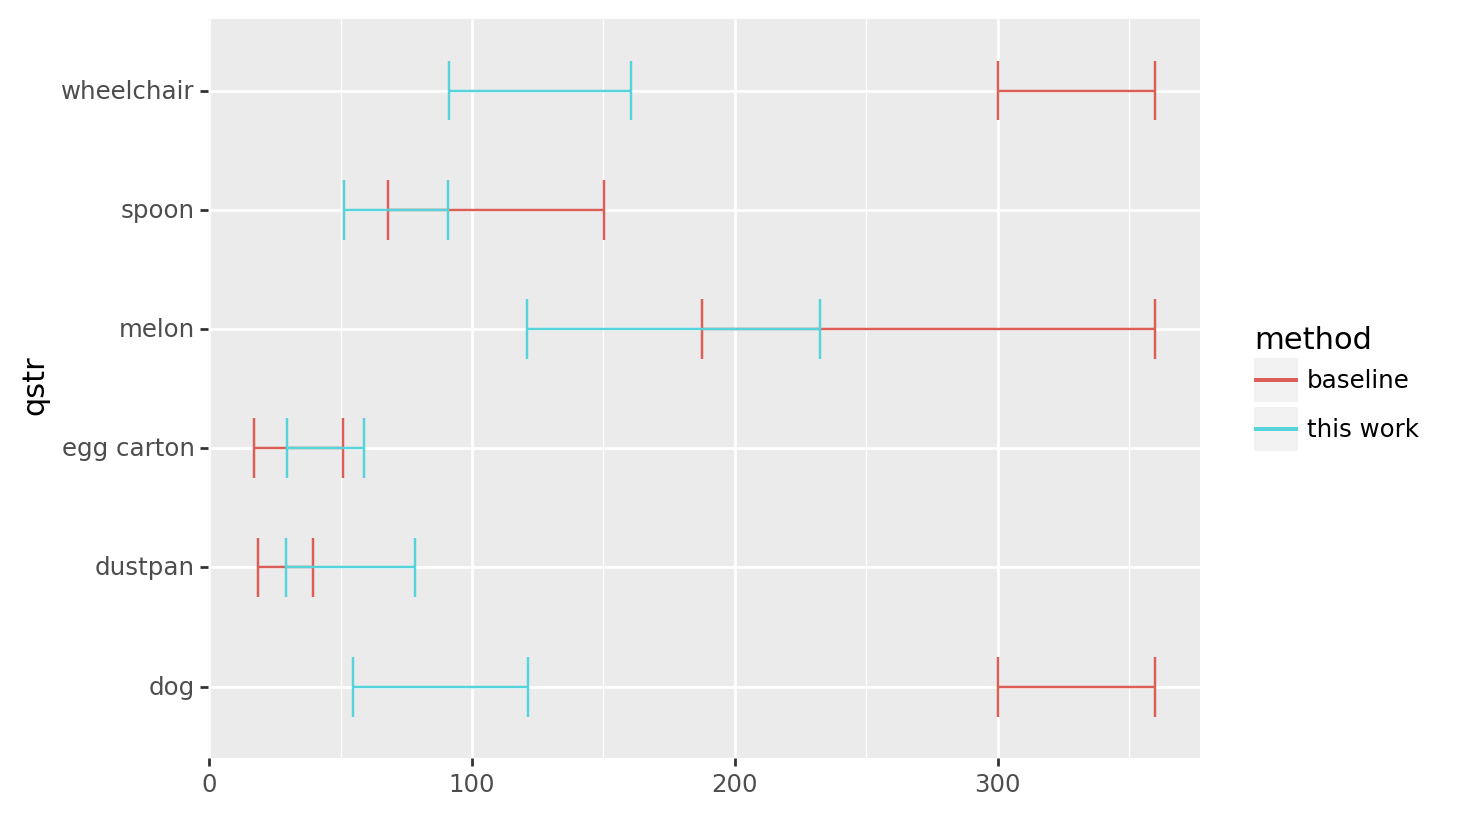

<ggplot: (8760869251759)>

In [129]:
(ggplot(data=qaccept_df) + 
     geom_errorbarh(aes(xmax='high', xmin='lower', color='method', y='qstr'
                       )
                   )  
#     geom_point(aes())
)

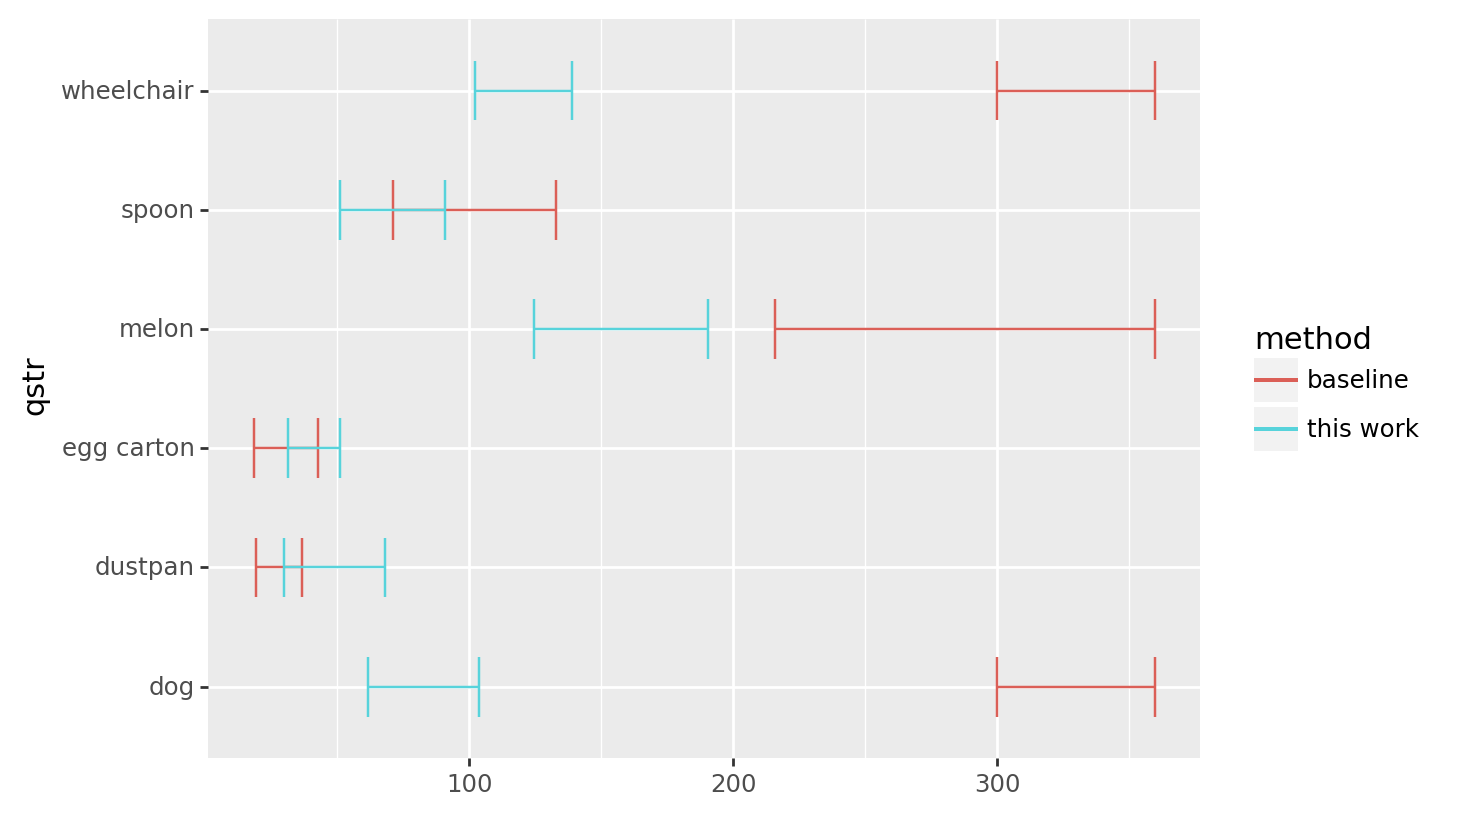

<ggplot: (8760869345931)>

In [125]:
(ggplot(data=qaccept_df) + 
     geom_errorbarh(aes(xmax='high', xmin='lower', color='method', y='qstr'
                       )
                   )  
#     geom_point(aes())
)

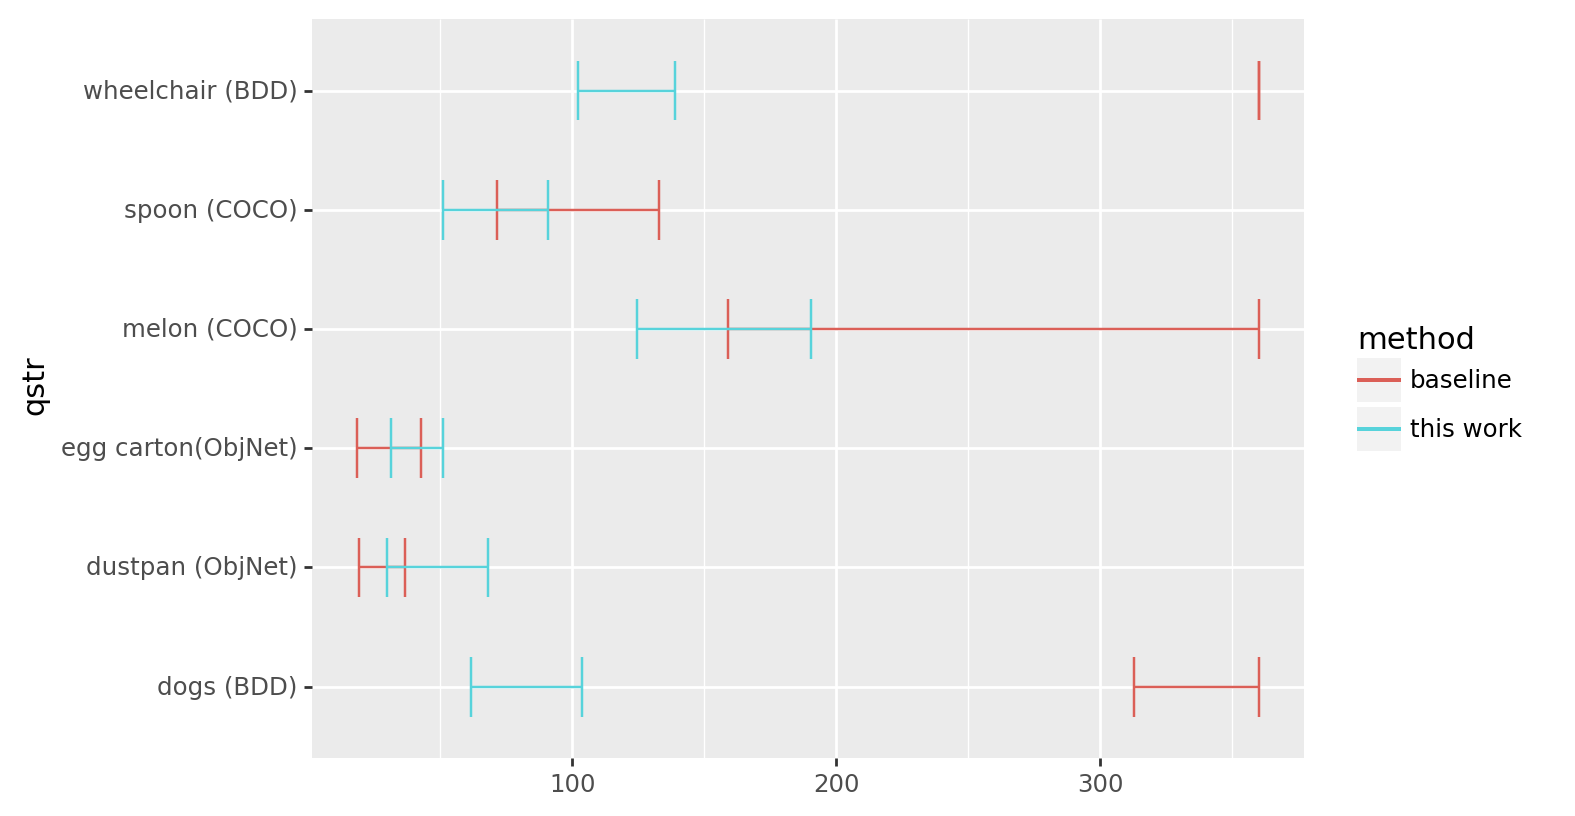

<ggplot: (8781364767859)>

In [127]:
(ggplot(data=qaccept_df) + 
     geom_errorbarh(aes(xmax='high', xmin='lower', color='method', y='qstr'
                       )
                   ) + 
     geom_point(aes())
)

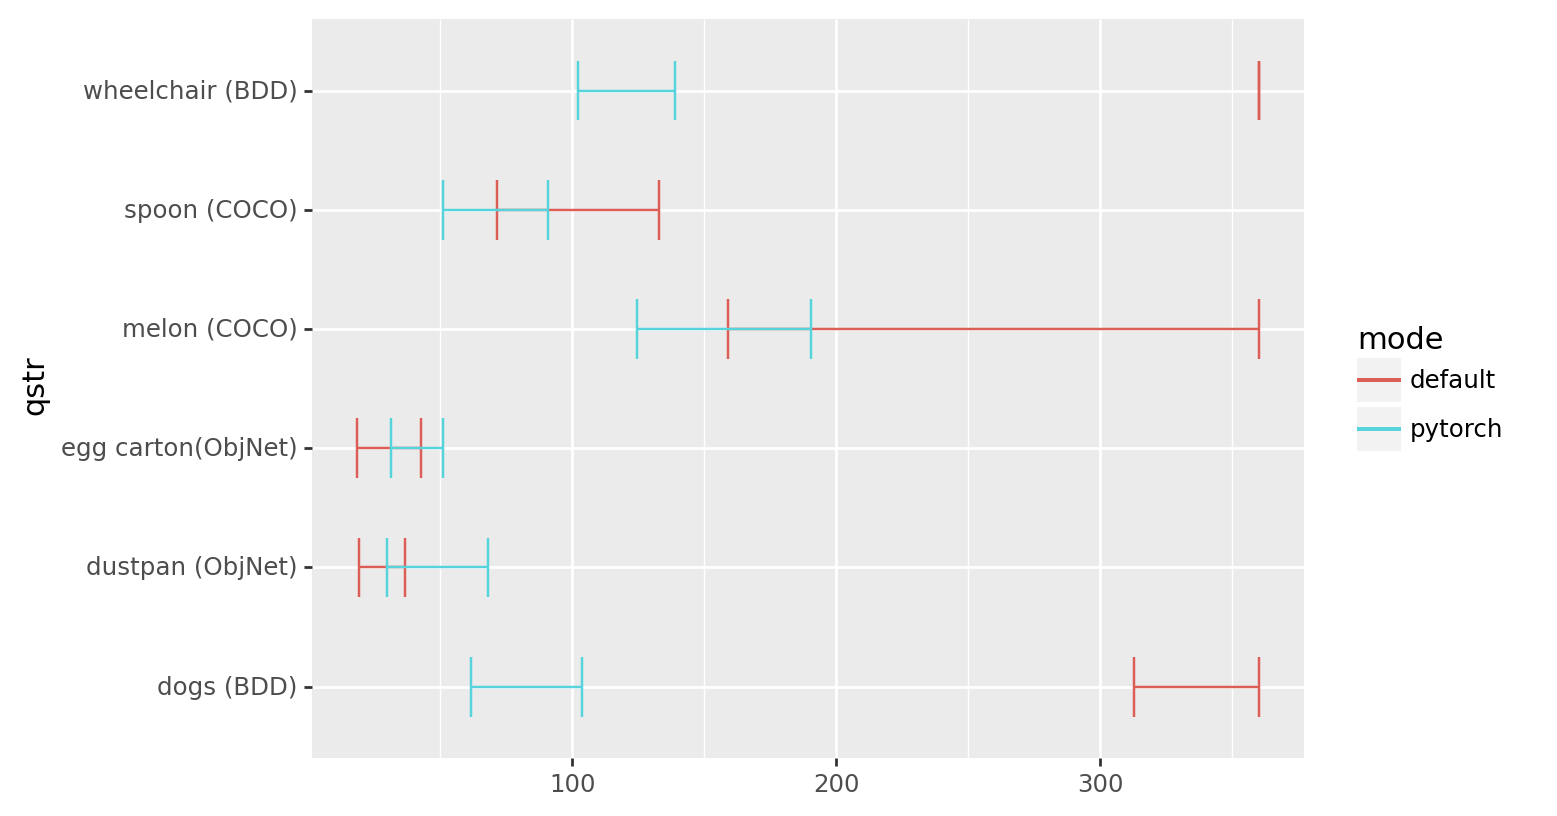

<ggplot: (8781382450523)>

In [98]:
(ggplot(data=slicedf) + 
     geom_errorbarh(aes(xmax='high', xmin='lower', color='mode', y='qstr'
                       ))
)

In [18]:
qaccept_df.to_parquet('user_grouped_by_num_accepted.parquet')

,qkey,mode,accepted,level_3,lower,med,mean,high,confidence_level,n,grp
10,cd,default,10,0,360.000000,360.000000,360.000000,360.000000,0.95,5,"(default, 10)"
21,cd,pytorch,10,0,230.444043,335.947000,315.066009,360.000000,0.95,5,"(pytorch, 10)"
32,dg,default,10,0,312.973000,360.000000,350.594600,360.000000,0.95,5,"(default, 10)"
43,dg,pytorch,10,0,61.705669,83.047000,88.723378,103.593000,0.95,13,"(pytorch, 10)"
54,dst,default,10,0,19.063500,28.727040,30.110447,36.725106,0.95,12,"(default, 10)"
65,dst,pytorch,10,0,29.611000,38.620500,47.739575,68.093081,0.95,10,"(pytorch, 10)"
76,gg,default,10,0,18.257000,29.679696,31.287671,42.690000,0.95,10,"(default, 10)"
87,gg,pytorch,10,0,31.413000,33.496544,42.710705,51.117978,0.95,14,"(pytorch, 10)"
98,mln,default,10,0,158.874675,220.534500,239.985919,360.000000,0.95,4,"(default, 10)"
109,mln,pytorch,10,0,124.655000,181.980069,180.550283,190.425831,0.95,11,"(pytorch, 10)"


In [35]:
qaccept_df = pd.read_parquet('./user_grouped_by_num_accepted.parquet')

FileNotFoundError: [Errno 2] No such file or directory: './user_grouped_by_num_accepted.parquet'

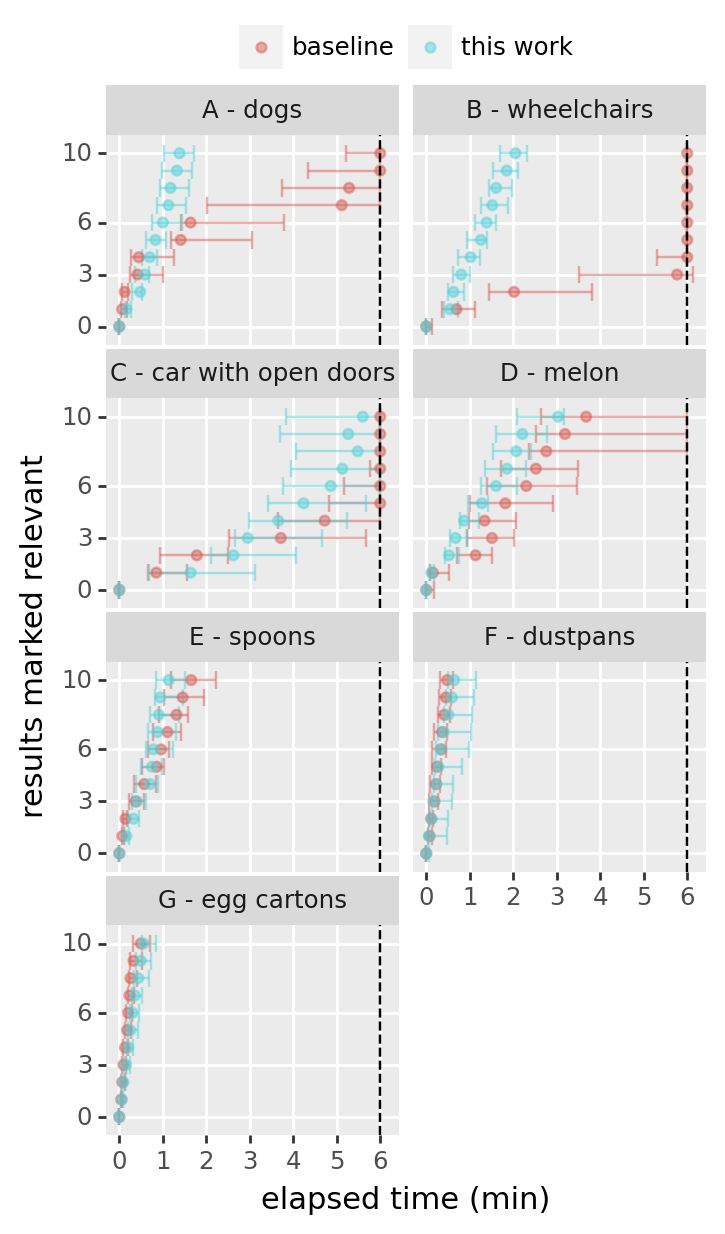

<ggplot: (8742187079385)>

In [27]:
plot = ( ggplot(qaccept_df) + 
     geom_errorbarh(aes(y='accepted', xmin='lower', xmax='high', 
                       group='grp', color='method'), height=1., alpha=.5, position='identity', show_legend=False) +
     geom_point(aes(y='accepted', x='med', group='grp', color='method'), alpha=.5, position='identity') +
#      geom_text(aes(y='accepted', x='high', label='n',
#                     group='grp', color='mode'), va='bottom', ha='left', alpha=.5, position='identity') +
     facet_wrap(['qstr'], ncol=2, ) +
     scale_x_continuous(breaks=[0, 60, 120, 180, 240, 300, 360], labels=lambda a : list(map(show_minutes,a)) )+
     scale_y_continuous(breaks=[0, 3, 6, 10]) +
     xlab('elapsed time (min)') +
     ylab('results marked relevant') + 
     annotate('vline', xintercept=6*60, linetype='dashed') +
#      annotate('text', label=360, x=360,y=0, va='top')
     theme(legend_position='top', legend_direction='horizontal', legend_title=element_blank(), legend_box_margin=0,
          legend_margin=0, plot_margin=0, panel_grid_minor=element_blank(), figure_size=(3,5), )
)
plot

In [11]:
# first approach: 
## instead of plot over time, just time needed

/nvme_drive/orm/seesaw/.seesaw_env/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/nvme_drive/orm/seesaw/.seesaw_env/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/nvme_drive/orm/seesaw/.seesaw_env/lib/python3.8/site-packages/plotnine/facets/facet.py:487: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/nvme_drive/orm/seesaw/.seesaw_env/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


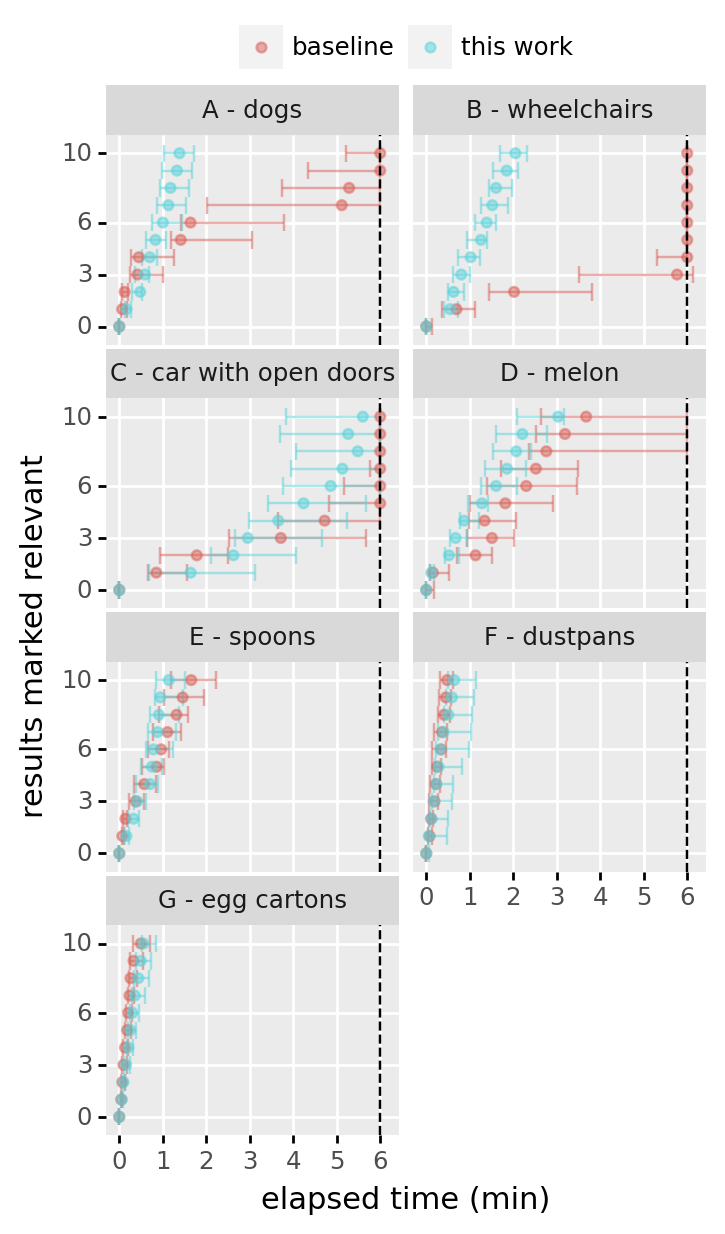

<ggplot: (8765356674850)>

In [101]:
plot = ( ggplot(qaccept_df) + 
     geom_errorbarh(aes(y='accepted', xmin='lower', xmax='high', 
                       group='grp', color='method'), height=1., alpha=.5, position='identity', show_legend=False) +
     geom_point(aes(y='accepted', x='med', group='grp', color='method'), alpha=.5, position='identity') +
#      geom_text(aes(y='accepted', x='high', label='n',
#                     group='grp', color='mode'), va='bottom', ha='left', alpha=.5, position='identity') +
     facet_wrap(['qstr'], ncol=2, ) +
     scale_x_continuous(breaks=[0, 60, 120, 180, 240, 300, 360], labels=lambda a : list(map(show_minutes,a)) )+
     scale_y_continuous(breaks=[0, 3, 6, 10]) +
     xlab('elapsed time (min)') +
     ylab('results marked relevant') + 
     annotate('vline', xintercept=6*60, linetype='dashed') +
#      annotate('text', label=360, x=360,y=0, va='top')
     theme(legend_position='top', legend_direction='horizontal', legend_title=element_blank(), legend_box_margin=0,
          legend_margin=0, plot_margin=0, panel_grid_minor=element_blank(), figure_size=(3,5), )
)
plot

In [84]:
import matplotlib.pyplot as plt

/nvme_drive/orm/seesaw/.seesaw_env/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/nvme_drive/orm/seesaw/.seesaw_env/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/nvme_drive/orm/seesaw/.seesaw_env/lib/python3.8/site-packages/plotnine/facets/facet.py:487: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/nvme_drive/orm/seesaw/.seesaw_env/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


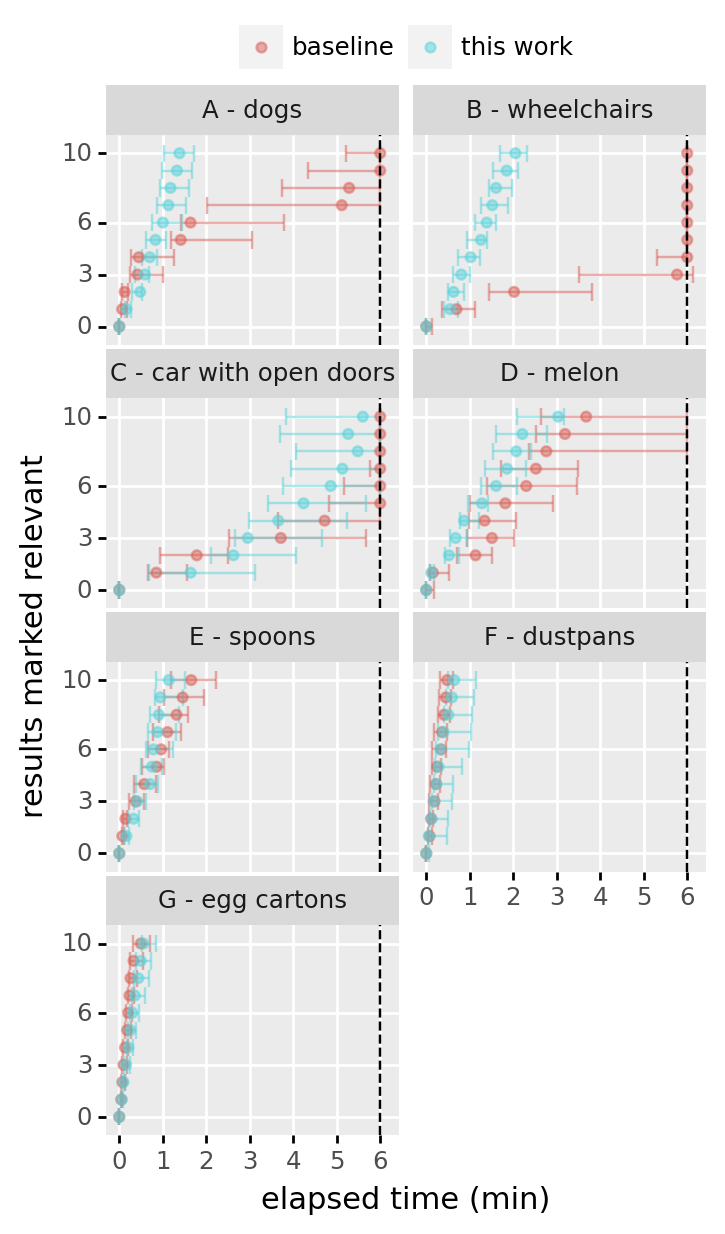

In [102]:
f2 = plot.draw()

In [106]:
f2.savefig('./user_study.pdf', bbox_inches='tight', dpi=200)

In [104]:
import PIL.Image

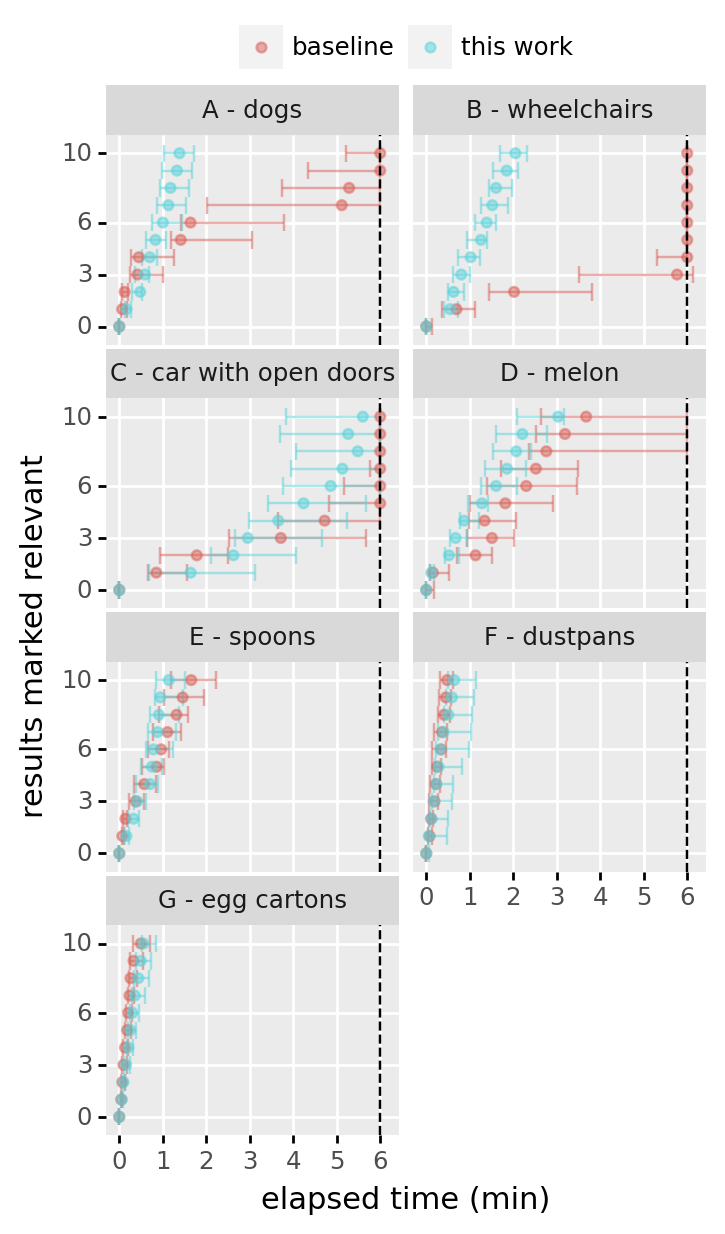

In [105]:
PIL.Image.open('./user_study.png')